In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from sklearn.model_selection import train_test_split
from tabulate import tabulate

## Prepare train and test data sets

Prepare dataframes of the file paths for the train, test and validation data sets

In [4]:
dir_path = "./data/"
file_paths = []
labels = []
folders = os.listdir(dir_path)

In [5]:
for folder in folders:
    fold_path = dir_path + folder
    for file in os.listdir(fold_path):
        file_paths.append(fold_path + "/" + file)
        labels.append(folder)

In [6]:
df = pd.DataFrame({"file_path": file_paths, "label": labels}).sample(frac=1)
df.head()

,file_path,label
19225,./data/Uninfected/C112P73ThinF_IMG_20150930_13...,Uninfected
13619,./data/Parasitized/C100P61ThinF_IMG_20150918_1...,Parasitized
20930,./data/Uninfected/C107P68ThinF_IMG_20150924_22...,Uninfected
20318,./data/Uninfected/C73P34_ThinF_IMG_20150815_11...,Uninfected
18216,./data/Uninfected/C180P141NThinF_IMG_20151201_...,Uninfected


In [7]:
df.describe()

,file_path,label
count,27560,27560
unique,27560,2
top,./data/Uninfected/C135P96ThinF_IMG_20151005_12...,Uninfected
freq,1,13780


In [8]:
df.reset_index(inplace=True, drop=True)
df.head(5)

,file_path,label
0,./data/Uninfected/C112P73ThinF_IMG_20150930_13...,Uninfected
1,./data/Parasitized/C100P61ThinF_IMG_20150918_1...,Parasitized
2,./data/Uninfected/C107P68ThinF_IMG_20150924_22...,Uninfected
3,./data/Uninfected/C73P34_ThinF_IMG_20150815_11...,Uninfected
4,./data/Uninfected/C180P141NThinF_IMG_20151201_...,Uninfected


In [9]:
train_df, tv_df = train_test_split(df, test_size=0.2, shuffle=True)

In [10]:
valid_df, test_df = train_test_split(tv_df, test_size=0.5, shuffle=True)

In [11]:
# Get the size of the DataFrames
print(tabulate([["train_df", len(train_df)], ["test_df", len(test_df)], ["valid_df", len(valid_df)]], headers=["df", "no of samples"]))
print(f"The total number of detected file paths is: {len(df)}")

df          no of samples
--------  ---------------
train_df            22048
test_df              2756
valid_df             2756
The total number of detected file paths is: 27560


### Plot some of the images

Get a feel of the dataset haha

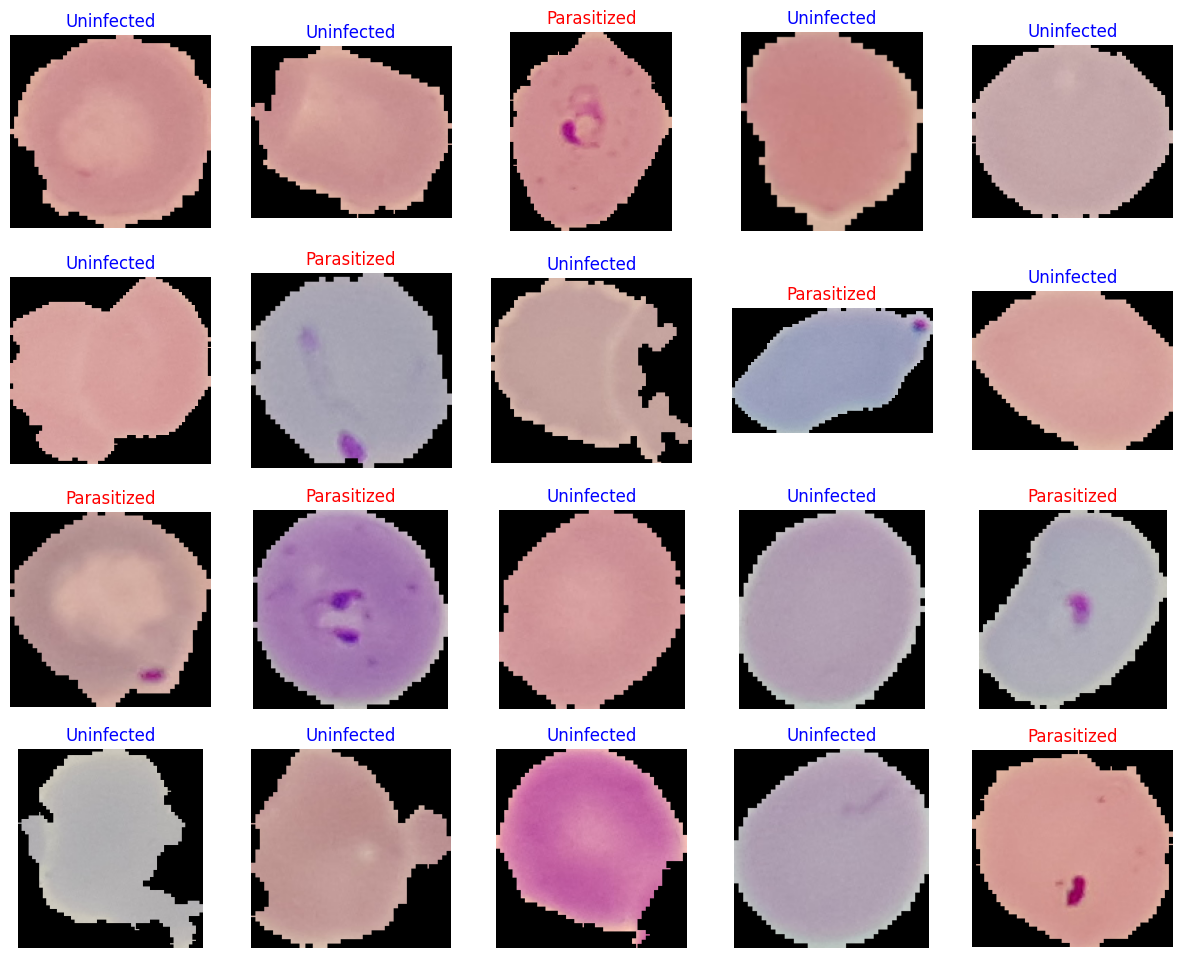

In [12]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 5, i+1)
    sample = train_df.sample().iloc[0]
    file_path = sample.file_path
    label = sample.label
    plt.imshow(image.load_img(file_path))
    color = "blue" if label=="Uninfected" else "red"
    plt.title(label, color=color, fontsize= 12)
    plt.axis('off')

## Train the model

In [13]:
# Get the number of classes - should be 2 (parasitized and uninfected)
K = df.label.nunique()
K

2

In [14]:
IMG_SIZE = (224, 224)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
TRAIN_VALID_BATCH_SIZE = 64
ts_length = len(test_df)
TEST_BATCH_SIZE = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

In [15]:
gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [16]:
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 22047 validated image filenames belonging to 2 classes.


In [17]:
test_gen = gen.flow_from_dataframe(
    test_df,
    x_col="file_path",
    y_col="label",
    shuffle=False,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE
)

Found 2756 validated image filenames belonging to 2 classes.


In [18]:
valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col="file_path",
    y_col="label",
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=TRAIN_VALID_BATCH_SIZE
)

Found 2755 validated image filenames belonging to 2 classes.


In [20]:
base_model = MobileNetV3Small(
    input_shape=IMG_SHAPE,
    weights="imagenet",
    include_top=False
)

In [21]:
base_model.summary()

Model: "MobilenetV3small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [22]:
base_model.trainable = False

In [23]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(K, activation="softmax")
])

In [24]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [25]:
epochs = 15
r = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    shuffle=False
)

Epoch 1/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.8754 - loss: 0.3664 - val_accuracy: 0.9448 - val_loss: 0.2394
Epoch 2/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.9381 - loss: 0.2192 - val_accuracy: 0.9492 - val_loss: 0.1893
Epoch 3/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.9459 - loss: 0.1802 - val_accuracy: 0.9452 - val_loss: 0.1648
Epoch 4/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.9548 - loss: 0.1418 - val_accuracy: 0.9554 - val_loss: 0.1378
Epoch 5/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.9517 - loss: 0.1443 - val_accuracy: 0.9543 - val_loss: 0.1340
Epoch 6/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9547 - loss: 0.1294 - val_accuracy: 0.9593 - val_loss: 0.1251
Epoch 7/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.9554 - loss: 0.1330 - val_accuracy: 0.9564 - val_loss: 0.1237
Epoch 8/15
345/345 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.9579 - loss: 0.1253 - val_accu

## Model Evaluation

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 576)      │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │        25,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,462,136 (5.58 MB)

 Trainable params: 173,954 (679.51 KB)

 Non-trainable params: 940,272 (3.59 MB)

 Optimizer params: 347,910 (1.33 MB)

In [28]:
tr_acc = r.history['accuracy']
tr_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

#### Plot train history

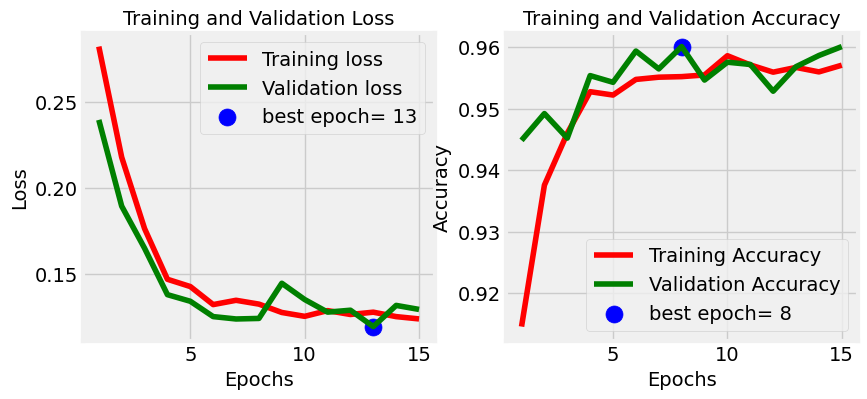

In [29]:
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')

# Plot training and validation losses 
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend();

In [30]:
test_length = len(test_df)
steps = test_length // TEST_BATCH_SIZE
test_score = model.evaluate(test_gen, steps=steps)

52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9660 - loss: 0.1222


In [32]:
print(f"Test loss: {test_score[0]: .06f}")
print(f"Test accuracy: {round(test_score[1]*100)}%") 

Test loss:  0.123539
Test accuracy: 96%


### Generate confusion matrix and classification report

In [33]:
Yhat = np.argmax(model.predict(test_gen), axis=1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 49s 908ms/step


In [34]:
Ytrue = test_gen.classes
labels = list(test_gen.class_indices.keys())

#### Confusion matrix

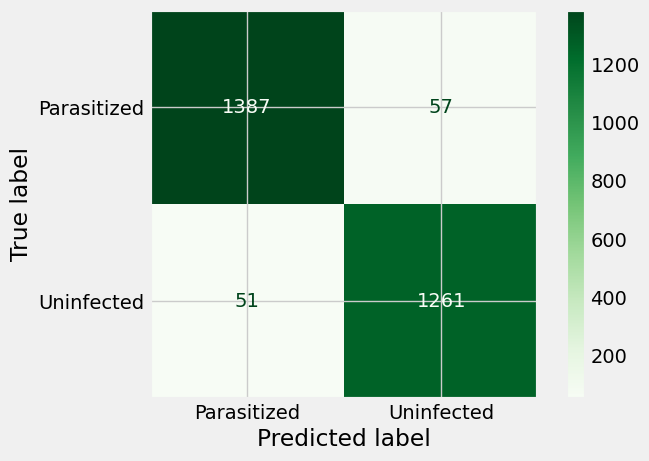

In [35]:
cm = confusion_matrix(y_true=np.array(Ytrue).flatten(), y_pred=Yhat.flatten())
display = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices)
display.plot(cmap="Greens");

#### Classification report

In [36]:
print(classification_report(y_true=Ytrue, y_pred=Yhat, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.96      0.96      0.96      1444
  Uninfected       0.96      0.96      0.96      1312

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



## Save the model

In [37]:
model.save("malaria_diagnosis_mobilenetv3Small.keras")